# Stock Price Indicator
## I. ETL Pipeline Preparation
### 1. Import libraries and load datasets.
- Import Python libraries
- Load data from Yahoo Finance (Accessing data from the Yahoo finance plattform via the corresponing API you are able to download data since 1950 (if the stock existed))

In [502]:
# import libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

import yfinance as yf
from alpha_vantage.timeseries import TimeSeries

API_key = 'AG0F6BKQTUPYSY99' 


In [529]:
ts = TimeSeries(key = API_key, output_format = 'pandas')

symbol = 'AAPL'
data = ts.get_daily_adjusted(symbol)
df = data[0]['5. adjusted close'].reset_index()
df.to_csv('app/'+symbol+'.csv', index = False)

In [26]:
# Import data from Yahoo finance

def get_data(symbol='AAPL', start_date='2020-01-01', end_date='2020-12-31'):
    '''
    Setup of an empty dataframe with the given timeperiod as index to be used as instance for further gathered data.
    Then downloads the data from Yahoo Finance for the selected symbol(s) and time period and selects the Adj Close column
    INPUT: 
    symbols - list - symbols of listed stocks
    start_date - datetime - Beginning of the period to analyze
    end_date - datetime - End of the period to analyze
    
    OUTPUT
    df - dataframe - Dataframe containing the Adj Close for each symbol with the time period as index (ordered ascending)
    '''
    dates= pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    
    df_tmp = yf.download(symbol, start_date, end_date)
    df_tmp = df_tmp[['Adj Close']]
    df_tmp = df_tmp.rename(columns={"Adj Close": symbol})
        
    df = df.join(df_tmp)
    df = df.dropna()
    
    return df

In [435]:
data_analysis_df = get_data(symbol='BABA', start_date='2020-01-25', end_date='2021-05-25')
data_analysis_df.head()

[*********************100%***********************]  1 of 1 completed


,BABA
2020-01-27,205.470001
2020-01-28,210.229996
2020-01-29,212.020004
2020-01-30,208.580002
2020-01-31,206.589996


### 2. Normalize data and plot to check for anomalies

In [436]:
# Noramlize the stock price data

def normalize_stock_data(df):
    df = df/df.iloc[0,:]
    return df

In [437]:
data_analysis_norm = normalize_stock_data(data_analysis_df)

In [438]:
# Plot stock price data and check for anomalies

def plot_stock_data(df):
    if isinstance(df, pd.Series):
        plt.figure(figsize=(12,8))
        ax1 = df.plot()
        ax1.set_xlabel('time')
        ax1.set_ylabel('price')
        ax1.set_title('Stock price development')
        plt.legend(loc='upper right')
        plt.show()
    else:
        plt.figure(figsize=(12,18))
        ax2 = plt.subplot(2,1,1)
        ax2.set_xlabel('time')
        ax2.set_ylabel('price')
        ax2.set_title('Stock price development')
        for col in df.columns:
            df[col].plot()
    
        plt.legend(loc='upper right')

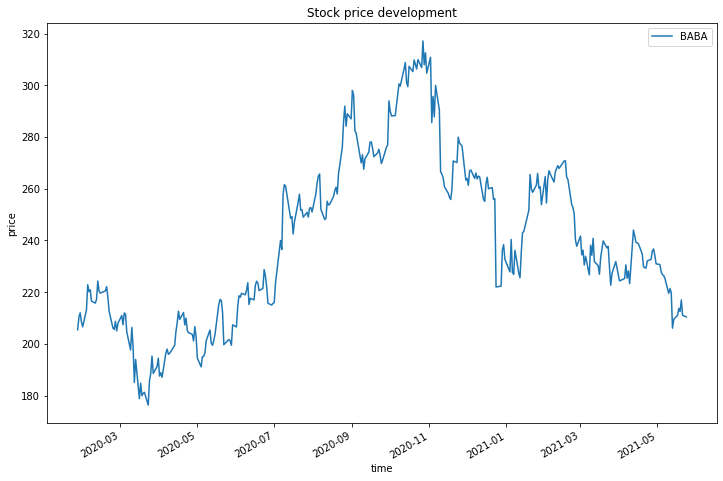

In [439]:
plot_stock_data(data_analysis_df)

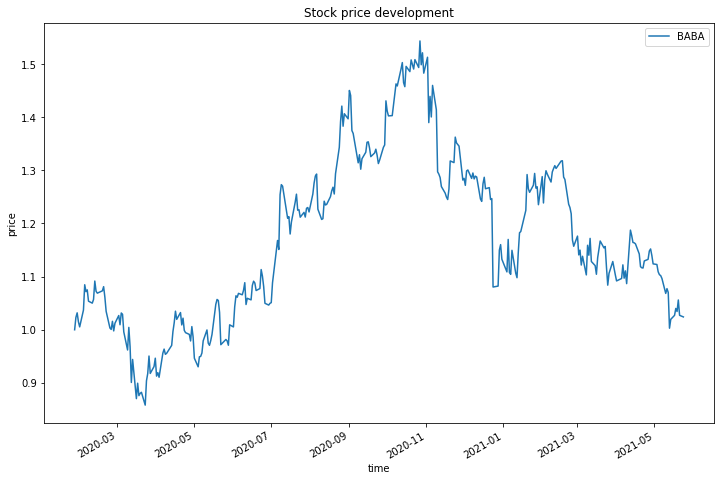

In [440]:
plot_stock_data(data_analysis_norm)

### 3. Feature engineering

In [441]:
# Simple moving average (SMA)

win = 10
sma = data_analysis_norm.rolling(window=win).mean()
std_df = data_analysis_norm.rolling(window=win).std()
sma.tail()
std_df.tail()

,BABA
2021-05-18,0.036260
2021-05-19,0.033684
2021-05-20,0.029241
2021-05-21,0.024653
2021-05-24,0.023395


In [442]:
# Bollinger(R) Bands

def get_bollinger_bands(rm=sma, rstd=std_df):
    upper_band = rm + rstd*2
    lower_band = rm - rstd*2
    return upper_band, lower_band


In [443]:
b_upper_band, b_lower_band = get_bollinger_bands()
b_upper_band.tail()

,BABA
2021-05-18,1.133347
2021-05-19,1.121264
2021-05-20,1.107788
2021-05-21,1.091677
2021-05-24,1.084737


In [444]:
# Daily returns

def get_daily_returns(df=data_analysis_df):
    daily_returns = df.copy()
    daily_returns[1:] = (df[1:]/df[:-1].values) - 1
    daily_returns.iloc[0,:] = 0
    return daily_returns

In [445]:
daily_returns = get_daily_returns()
daily_returns.head()

,BABA
2020-01-27,0.000000
2020-01-28,0.023166
2020-01-29,0.008515
2020-01-30,-0.016225
2020-01-31,-0.009541


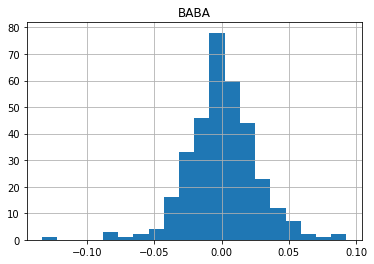

In [446]:
daily_returns.hist(bins= 20)
plt.show()

In [447]:
# Cumulative returns

def get_cumulative_returns(df=data_analysis_df):
    cumulative_returns = df.copy
    cumulative_returns= (df/df.iloc[0]) - 1
    return cumulative_returns

In [448]:
cumulative_returns = get_cumulative_returns()
cumulative_returns.head()

,BABA
2020-01-27,0.000000
2020-01-28,0.023166
2020-01-29,0.031878
2020-01-30,0.015136
2020-01-31,0.005451


In [449]:
# Momentum

def get_momentum(df=data_analysis_df, win=5):
    df_momentum = df.copy()
    df_momentum[win:] = (df[win:]/df[:-(win)].values) - 1
    df_momentum.iloc[0:(win),:] = 0
    return df_momentum

In [450]:
momentum = get_momentum()
momentum.tail()

,BABA
2021-05-18,-0.034601
2021-05-19,-0.033470
2021-05-20,0.052941
2021-05-21,0.007398
2021-05-24,-0.002890


In [451]:
# Get market index

market_index = get_data(symbol='SPY', start_date='2020-01-25', end_date='2021-05-25')
market_index.head(), market_index.tail()


[*********************100%***********************]  1 of 1 completed


(                   SPY
 2020-01-27  316.532745
 2020-01-28  319.849731
 2020-01-29  319.585510
 2020-01-30  320.622711
 2020-01-31  314.800873,
                    SPY
 2021-05-18  411.940002
 2021-05-19  410.859985
 2021-05-20  415.279999
 2021-05-21  414.940002
 2021-05-24  419.170013)

### 4. Merge all indicators and symbols into one dataframe

In [452]:
def create_indicator_dataframe(df):
    ''' Function which which takes the Adj Close and corresponding dates per symbol, adds a new column containing the symbol 
        and joins all indicators to one dataframe 
        INPUT: 
        df - dataframe - contains the orginal data to analyse 
        OUTPUT:
        indicator_df - dataframe - contains the Adj Close and all indicators as features tagged by the symbol '''
    indicator_df = pd.DataFrame(columns=['Date','Symbol', 'Adj Close','Daily Returns','Cumulative Returns','SMA', 'Momentum', 'Upper Band','Lower Band','Market Index'])
    
    for symbol in df.columns:
        df_temp = df[symbol].reset_index().rename(columns={'index':'Date', symbol:'Adj Close'})
        df_temp['Symbol']= symbol

        df_temp = df_temp.join(daily_returns[symbol], on='Date').rename(columns={symbol:'Daily Returns'})
        df_temp = df_temp.join(cumulative_returns[symbol], on='Date').rename(columns={symbol:'Cumulative Returns'})
        df_temp = df_temp.join(sma[symbol], on='Date').rename(columns={symbol:'SMA'})
        df_temp = df_temp.join(momentum[symbol], on='Date').rename(columns={symbol:'Momentum'})
        df_temp = df_temp.join(b_upper_band[symbol], on='Date').rename(columns={symbol:'Upper Band'})
        df_temp = df_temp.join(b_lower_band[symbol], on='Date').rename(columns={symbol:'Lower Band'})
        df_temp = df_temp.join(market_index['SPY'], on='Date').rename(columns={'SPY':'Market Index'})
        indicator_df = pd.concat([indicator_df, df_temp])
        
        indicator_df.fillna(method='ffill', inplace=True)
        indicator_df.fillna(method='bfill', inplace=True)
        indicator_df.dropna()
    
    return indicator_df

In [453]:
indicator_model_df = create_indicator_dataframe(data_analysis_df)
indicator_model_df

,Date,Symbol,Adj Close,Daily Returns,Cumulative Returns,SMA,Momentum,Upper Band,Lower Band,Market Index
0,2020-01-27,BABA,205.470001,0.000000,0.000000,1.039821,0.000000,1.100203,0.979439,316.532745
1,2020-01-28,BABA,210.229996,0.023166,0.023166,1.039821,0.000000,1.100203,0.979439,319.849731
2,2020-01-29,BABA,212.020004,0.008515,0.031878,1.039821,0.000000,1.100203,0.979439,319.585510
3,2020-01-30,BABA,208.580002,-0.016225,0.015136,1.039821,0.000000,1.100203,0.979439,320.622711
4,2020-01-31,BABA,206.589996,-0.009541,0.005451,1.039821,0.000000,1.100203,0.979439,314.800873
...,...,...,...,...,...,...,...,...,...,...
330,2021-05-18,BABA,213.720001,0.012651,0.040152,1.060826,-0.034601,1.133347,0.988306,411.940002
331,2021-05-19,BABA,212.539993,-0.005521,0.034409,1.053896,-0.033470,1.121264,0.986528,410.859985
332,2021-05-20,BABA,216.990005,0.020937,0.056067,1.049306,0.052941,1.107788,0.990825,415.279999
333,2021-05-21,BABA,211.059998,-0.027328,0.027206,1.042371,0.007398,1.091677,0.993065,414.940002


## II. MACHINE LEARNING PIPELINE 

### 1. Create train and test data and standardize

In [454]:
from sklearn import preprocessing

def create_train_test_data(indicator_df, symbol, train_size=0.8, start_pred='2021-05-07', end_pred='2021-05-14'):
    ''' Splits the indicator dataframe into a train and test dataset and standardizes the data of the indipendent variable
        INPUT:
        indicator_df - dataframe object - dataframe which contains the Adj Close and different indicators for each symbol
        symbol - str - symbol of the listed company for which you want to predict stock price
        train_size - float - size of train dataset
        start_pred - str - start date of prediction
        end_pred - str - end date of prediction
        OUTPUT:
        pred_days - int - days to be predicted
        Y_train - 1d array - contains the training dataset of the dependent variable (stock price)
        Y_test - 1d array - contains the test dataset of the dependent variable (stock price)
        X_train - nd array - contains the training dataset of the independent variables
        X_test - nd array - contains the test dataset of the independent variables
        X_predict = nd array - contains the data of the independent variable for the prediction period
        time_series_train - 1d array - selected time period of training data
        time_series_test - 1d array - selected time period of test data
    '''
    sd = dt.datetime.strptime(start_pred, '%Y-%m-%d')
    ed = dt.datetime.strptime(end_pred, '%Y-%m-%d')
    
    try:
        if sd >= ed:
            raise ValueError('Start date beyound end date')
        else:
            pred_days = (ed-sd).days

            indicator_df = indicator_df[indicator_df['Date'] <= start_pred] 
            
            df = indicator_df.copy().drop(['Symbol','Date'], axis=1)
            
            for i in range(1,pred_days):
                indicator_df=indicator_df.join(df.shift(i), rsuffix="[{} day before]".format(i))

        
            train_df = indicator_df.copy().iloc[pred_days:] # Training data starts from the date where data for all indicators is available
            
            if pred_days > 0:
                X = train_df.iloc[:-pred_days,3:] # Reduces the X Date by the number of pred_days at the end of the dataframe
                X_predict = train_df.iloc[-pred_days:, 3:]
                Y = train_df.drop('Symbol', axis=1).iloc[pred_days:,:2] # Starts at pred_days and takes all data until the end of the dataframe
                
                X.fillna(method='ffill', inplace=True)
                X.fillna(method='bfill', inplace=True)

                Y.fillna(method='ffill', inplace=True)
                Y.fillna(method='bfill', inplace=True)
                
            
            train_ct = int(X.shape[0] * train_size)
            test_ct = X.shape[0] - train_size

            X_train, X_test = X.iloc[:train_ct], X.iloc[train_ct:]  
            Y_train, Y_test = Y.iloc[:train_ct].copy().drop('Date', axis=1), Y.iloc[train_ct:].copy().drop('Date', axis=1)

            time_series_train = Y.iloc[:train_ct].Date
            time_series_test = Y.iloc[train_ct:].Date   


            return pred_days, preprocessing.scale(X_train), Y_train['Adj Close'].tolist(), preprocessing.scale(X_test), Y_test['Adj Close'].tolist(), time_series_train, time_series_test, preprocessing.scale(X_predict)
        
    
    except ValueError:
        raise
        

In [455]:
pred_days, X_train, Y_train, X_test, Y_test, time_series_train, time_series_test, X_predict   = create_train_test_data(indicator_model_df, symbol='AAPL', train_size=0.8)

In [456]:
pred_days, len(X_train), len(Y_train),  len(time_series_train)

(7, 248, 248, 248)

In [457]:
len(X_test), len(Y_test),len(time_series_test)

(62, 62, 62)

### 2. Setup and validate different models

In [458]:
from sklearn import linear_model

from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


In [474]:
# Evaluate model performance and plot data
def evaluate_model_performance(Y_test, Y_predict, Y_future, time_series_test):
    ''' Function that generates different performance indicators comparing test data and the predicted data
        and plots the data
        INPUT:
        Y_test - 1d array - contains the test dataset of the dependent variable (stock price)
        Y_predict - 1d array - contains the predicted dataset of the dependent variable (stock price) for the test period
        Y_future - 1d array - contains the predicted dataset of the dependent variable (stock price) for a future period
        time_series_test - 1d array - selected time period of test data
    '''
    
    corr = np.corrcoef(Y_test, Y_predict)
    corrcoef = corr[0,1]
    mae = mean_absolute_error(Y_test, Y_predict)
    mape = mean_absolute_percentage_error(Y_test, Y_predict)
    r2 = r2_score(Y_test, Y_predict)
    
    fig = plt.figure(figsize=(12,8))
    
    value_days = len(Y_future)
    end_date = (time_series_test.iloc[-1] + dt.timedelta(days=value_days+1))

    time_series_future = pd.date_range(time_series_test.iloc[-1]+ dt.timedelta(days=2) , end_date).tolist()

    plt.plot(time_series_test, Y_test, color='lightblue', linewidth=2, label='test data')
    plt.plot(time_series_test, Y_predict.reshape(-1,1), color='red',  linewidth=2, label='predicted data')
    
    plt.plot(time_series_future , Y_future.reshape(-1,1), color='green',  linewidth=2, label='future predicted data')
    
    plt.legend()
    
    return print(('MAE {} \n MAPE {} \n r2 {} \n CORRCOEF {} \n').format(mae, mape, r2 , corrcoef))

In [475]:
# Lasso LARS

lassolars = linear_model.LassoLars(alpha = 0.1)
lassolars.fit(X_train, Y_train)
Y_lassolars_predict = lassolars.predict(X_test)
Y_lassolars_future = lassolars.predict(X_predict)

MAE 17.39339607903848 
 MAPE 0.07225269190596541 
 r2 -2.136634024744202 
 CORRCOEF 0.6846479385561578 



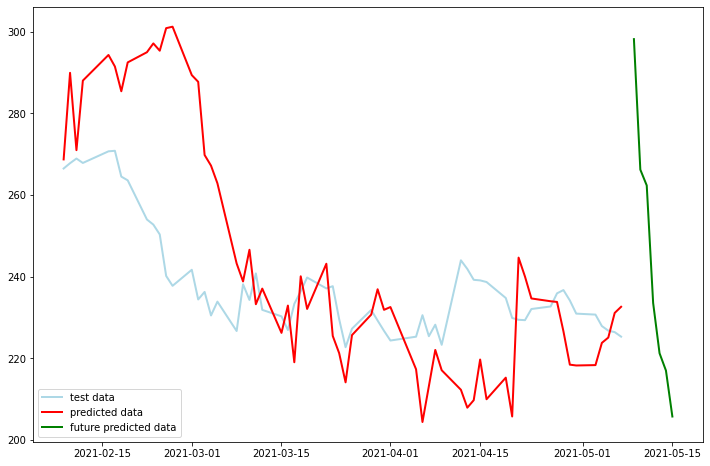

In [476]:
evaluate_model_performance(Y_test, Y_lassolars_predict, Y_lassolars_future, time_series_test)

In [462]:
Y_lassolars_future

array([298.17533436, 266.21405309, 262.34349868, 233.55463707,
       221.24443474, 217.00023408, 205.74962434])

In [463]:
# knn
knn = KNeighborsRegressor(n_neighbors=15)  #weights='distance'
knn.fit(X_train, Y_train)
Y_knn_predict = knn.predict(X_test)
Y_knn_future = knn.predict(X_predict)

RMSE 30.05744915441519 
 MSE 903.4502496702544 
 MAE 22.723645347677248 
 MAPE 0.09469848986270073 
 r2 -4.233337480778108 
 CORRCOEF 0.5827264884507792 



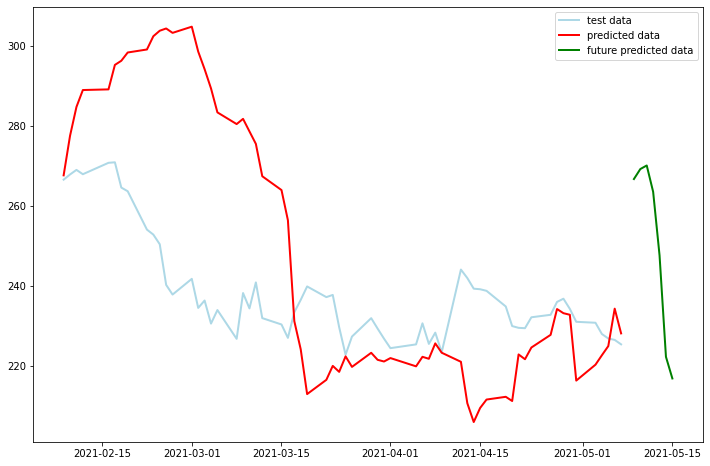

In [464]:
evaluate_model_performance(Y_test, Y_knn_predict, Y_knn_future, time_series_test)

In [465]:
# AdaBoost
AdaBoost = AdaBoostRegressor(base_estimator=knn, random_state=42)
AdaBoost.fit(X_train, Y_train)
Y_AdaBoost_predict = AdaBoost.predict(X_test)
Y_AdaBoost_future = AdaBoost.predict(X_predict)

RMSE 30.10494951440451 
 MSE 906.3079852648443 
 MAE 22.744237460885 
 MAPE 0.09486925799599341 
 r2 -4.249891236563531 
 CORRCOEF 0.5692680715689287 



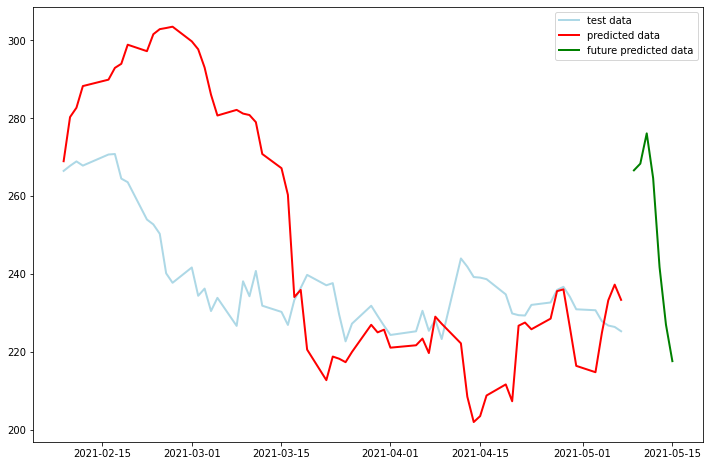

In [466]:
evaluate_model_performance(Y_test, Y_AdaBoost_predict, Y_AdaBoost_future, time_series_test)

In [467]:
# Random Forest Regression
randomforest = RandomForestRegressor(random_state=42, criterion='mse', n_estimators=10, min_samples_split=10)
randomforest.fit(X_train, Y_train)
Y_randomforest_predict = randomforest.predict(X_test)
Y_randomforest_future = randomforest.predict(X_predict)

RMSE 28.53909467623226 
 MSE 814.4799249389486 
 MAE 24.067687120276076 
 MAPE 0.10084748702457491 
 r2 -3.71796683888246 
 CORRCOEF 0.6554568664119451 



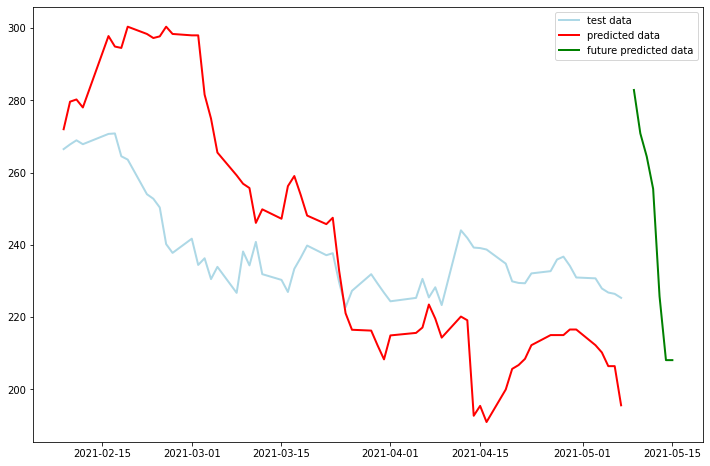

In [468]:
evaluate_model_performance(Y_test, Y_randomforest_predict, Y_randomforest_future, time_series_test)

### 3. Put all the above into one class

In [478]:
class StockDataAnalysis():
    ''' Creates a StockDataAnalysis object which is able to take one or mutiple stock symbols and a timeframe and then computes
        a range of indicators on the stock data and plots the results'''
    
    def __init__(self, symbol='AAPL', start_date='2020-01-01', end_date='2021-04-16'):
        ''' Create an instance of StockDataAnalysis'''
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        
        self.data = get_data(self.symbol, self.start_date, self.end_date)
        self.data_norm = normalize_stock_data(self.data)
        
    # Plot stock price data and check for anomalies

    def plot_stock_data(self, normalized=True):
        if normalized:
            df = self.data_norm
            title_str = 'Relative stock price development'
        else:
            df = self.data
            title_str = 'Absolute stock price development'
        if isinstance(df, pd.Series):
            plt.figure(figsize=(12,8))
            ax1 = df.plot()
            ax1.set_xlabel('time')
            ax1.set_ylabel('price')
            ax1.set_title(title_str)
            plt.legend(loc='upper right')
            plt.show()
        else:
            plt.figure(figsize=(12,18))
            ax2 = plt.subplot(2,1,1)
            ax2.set_xlabel('time')
            ax2.set_ylabel('price development')
            ax2.set_title(title_str)
            for col in df.columns:
                df[col].plot()
        
            plt.legend(loc='upper right')
           
    def calculate_rolling_stats(self, win=10):
        rm = self.data_norm.rolling(window=win).mean()
        rstd = self.data_norm.rolling(window=win).std()
        self.sma = rm.dropna()
        self.rstd = rstd.dropna()
        
    def calculate_bollinger_bands(self):
        self.b_upper_band = self.sma + self.rstd*2
        self.b_lower_band = self.sma - self.rstd*2
            
    def calculate_daily_returns(self):
        daily_returns = self.data.copy()
        daily_returns[1:] = (self.data[1:]/self.data[:-1].values) - 1
        daily_returns.iloc[0,:] = 0
        self.daily_returns = daily_returns
        

    def calculate_cumulative_returns(self):
        cumulative_returns = self.data.copy
        cumulative_returns= (self.data/self.data.iloc[0]) - 1
        self.cumulative_returns = cumulative_returns
        
        
    def calculate_momentum(self, win=5):
        self.momentum = self.data.copy()
        self.momentum[win:] = (self.data[win:]/self.data[:-(win)].values) - 1
        self.momentum.iloc[0:(win),:] = 0
        
    
    def get_market_index(self, market_ix='SPY'):
        self.market_ix = market_ix
        self.market_index = get_data(symbol=market_ix, start_date=self.start_date, end_date=self.end_date)
        
    def setup_features(self, market_ix='SPY'):
        self.calculate_rolling_stats()
        self.calculate_bollinger_bands()
        self.calculate_daily_returns()
        self.calculate_cumulative_returns()
        self.calculate_momentum()
        self.get_market_index(market_ix=market_ix)
        
            
    def create_indicator_dataframe(self):
        ''' Function which which takes the Adj Close and corresponding dates per symbol, adds a new column containing the symbol 
            and joins all indicators to one dataframe 
            INPUT: 
            object 
            OUTPUT:
            indicator_df - dataframe - contains the Adj Close and all indicators as features tagged by the symbol '''
        
        self.indicator_df = pd.DataFrame(columns=['Date','Symbol', 'Adj Close','Daily Returns','Cumulative Returns','SMA', 'Momentum', 'Upper Band','Lower Band','Market Index'])
        
        for symbol in self.data.columns:
            df_temp = self.data[symbol].reset_index().rename(columns={'index':'Date', symbol:'Adj Close'})
            df_temp['Symbol'] = symbol
            
            df_temp = df_temp.join(self.daily_returns[symbol], on='Date').rename(columns={symbol:'Daily Returns'})
            df_temp = df_temp.join(self.cumulative_returns[symbol], on='Date').rename(columns={symbol:'Cumulative Returns'})
            df_temp = df_temp.join(self.sma[symbol], on='Date').rename(columns={symbol:'SMA'})
            df_temp = df_temp.join(self.momentum[symbol], on='Date').rename(columns={symbol:'Momentum'})
            df_temp = df_temp.join(self.b_upper_band[symbol], on='Date').rename(columns={symbol:'Upper Band'})
            df_temp = df_temp.join(self.b_lower_band[symbol], on='Date').rename(columns={symbol:'Lower Band'})
            df_temp = df_temp.join(self.market_index[self.market_ix], on='Date').rename(columns={self.market_ix:'Market Index'})                   

            self.indicator_df = pd.concat([self.indicator_df, df_temp])
            
            self.indicator_df.fillna(method='ffill', inplace=True)
            self.indicator_df.fillna(method='bfill', inplace=True)
            self.indicator_df.dropna()

        return self.indicator_df

In [479]:
st_data = StockDataAnalysis('AAPL','2020-12-25','2021-05-21')

[*********************100%***********************]  1 of 1 completed


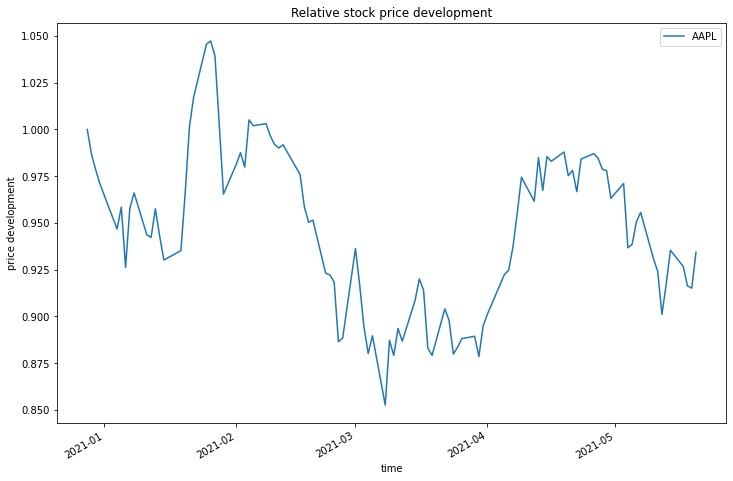

In [480]:
st_data.plot_stock_data()

In [481]:
st_data.setup_features()

[*********************100%***********************]  1 of 1 completed


In [482]:
st_data.calculate_rolling_stats()

In [483]:
st_data.calculate_bollinger_bands()

In [484]:
st_data.calculate_daily_returns()

In [485]:
st_data.calculate_momentum()

In [486]:
st_data.calculate_cumulative_returns()

In [487]:
st_data.get_market_index()

[*********************100%***********************]  1 of 1 completed


In [489]:
st_data.create_indicator_dataframe()
st_data.indicator_df

,Date,Symbol,Adj Close,Daily Returns,Cumulative Returns,SMA,Momentum,Upper Band,Lower Band,Market Index
0,2020-12-28,AAPL,136.254608,0.000000,0.000000,0.963450,0.000000,1.007037,0.919863,370.955048
1,2020-12-29,AAPL,134.440399,-0.013315,-0.013315,0.963450,0.000000,1.007037,0.919863,370.247345
2,2020-12-30,AAPL,133.294067,-0.008527,-0.021728,0.963450,0.000000,1.007037,0.919863,370.775604
3,2020-12-31,AAPL,132.267349,-0.007703,-0.029263,0.963450,0.000000,1.007037,0.919863,372.659454
4,2021-01-04,AAPL,128.997803,-0.024719,-0.053259,0.963450,0.000000,1.007037,0.919863,367.586090
...,...,...,...,...,...,...,...,...,...,...
95,2021-05-14,AAPL,127.449997,0.019845,-0.064619,0.936123,-0.021197,0.976016,0.896231,416.579987
96,2021-05-17,AAPL,126.269997,-0.009259,-0.073279,0.931687,-0.004572,0.963307,0.900066,415.519989
97,2021-05-18,AAPL,124.849998,-0.011246,-0.083701,0.929644,-0.008419,0.962435,0.896853,411.940002
98,2021-05-19,AAPL,124.690002,-0.001282,-0.084875,0.927301,0.015639,0.960606,0.893996,410.859985


In [490]:
class ModelStockPrice():
    def __init__(self, start_predict=None, end_predict=None):
        '''Create an instance of the model to predict stockprice'''
        
        self.start_predict = start_predict
        self.end_predict = end_predict
        
        self.model = linear_model.LassoLars(alpha = 0.1)


    def create_train_test_data(self, stockdata, train_size=0.8, start_pred='2019-05-10', end_pred='2019-05-17'):
        ''' Splits the indicator dataframe into a train and test dataset and standardizes the data of the indipendent variable
            INPUT:
            indicator_df - dataframe object - dataframe which contains the Adj Close and different indicators for each symbol
            symbol - str - symbol of the listed company for which you want to predict stock price
            train_size - float - size of train dataset
            start_pred - str - start date of prediction
            end_pred - str - end date of prediction
            OUTPUT:
            pred_days - int - days to be predicted
            Y_train - 1d array - contains the training dataset of the dependent variable (stock price)
            Y_test - 1d array - contains the test dataset of the dependent variable (stock price)
            X_train - nd array - contains the training dataset of the independent variables
            X_test - nd array - contains the test dataset of the independent variables
            X_predict = nd array - contains the data of the independent variable for the prediction period
            time_series_train - 1d array - selected time period of training data
            time_series_test - 1d array - selected time period of test data
            time_series_test - 1d array - predicted time period

        '''
        sd = dt.datetime.strptime(start_pred, '%Y-%m-%d')
        ed = dt.datetime.strptime(end_pred, '%Y-%m-%d')

        try:
            if sd >= ed:
                raise ValueError('Start date beyound end date')
            else:
                self.pred_days = (ed-sd).days

                indicator_df = stockdata.indicator_df[stockdata.indicator_df['Date'] <= start_pred] 

                df = stockdata.indicator_df.copy().drop(['Symbol','Date'], axis=1)

                for i in range(1, self.pred_days):
                    indicator_df=indicator_df.join(df.shift(i), rsuffix="[{} day before]".format(i))


                train_df = indicator_df.copy().iloc[self.pred_days:] # Training data starts from the date where data for all indicators is available

                if self.pred_days > 0:
                    X = train_df.iloc[:-pred_days,3:] # Reduces the X Date by the number of pred_days at the end of the dataframe
                    self.X_predict = preprocessing.scale(train_df.iloc[-pred_days:, 3:])
                    Y = train_df.drop('Symbol', axis=1).iloc[pred_days:,:2] # Starts at pred_days and takes all data until the end of the dataframe

                    X.fillna(method='ffill', inplace=True)
                    X.fillna(method='bfill', inplace=True)

                    Y.fillna(method='ffill', inplace=True)
                    Y.fillna(method='bfill', inplace=True)


                train_ct = int(X.shape[0] * train_size)
                test_ct = X.shape[0] - train_size

                self.X_train, self.X_test = preprocessing.scale(X.iloc[:train_ct]), preprocessing.scale(X.iloc[train_ct:])  
                self.Y_train, self.Y_test = Y.iloc[:train_ct]['Adj Close'].copy().tolist(), Y.iloc[train_ct:]['Adj Close'].copy().tolist()

                self.time_series_train = Y.iloc[:train_ct].Date
                self.time_series_test = Y.iloc[train_ct:].Date   


                return self.pred_days, self.X_train, self.Y_train, self.X_test, self.Y_test, self.time_series_train, self.time_series_test, X_predict


        except ValueError:
            raise

            
    def fit(self):
        '''Fit the model with training data '''
        self.model.fit(self.X_train, self.Y_train)

    def predict(self):
        '''Predict stockprice '''
        self.Y_predict = self.model.predict(self.X_test)
        self.Y_future = self.model.predict(self.X_predict)
        return self.Y_predict, self.Y_future
    
    def evaluate_model_performance(self):
        ''' Function that generates different performance indicators comparing test data and the predicted data
            and plots the data
            INPUT:
            Y_test - 1d array - contains the test dataset of the dependent variable (stock price)
            Y_predict - 1d array - contains the predicted dataset of the dependent variable (stock price) for the test period
            Y_future - 1d array - contains the predicted dataset of the dependent variable (stock price) for a future period
            time_series_test - 1d array - selected time period of test data
        '''

        corr = np.corrcoef(self.Y_test, self.Y_predict)
        corrcoef = corr[0,1]
        mae = mean_absolute_error(self.Y_test, self.Y_predict)
        mape = mean_absolute_percentage_error(self.Y_test, self.Y_predict)
        r2 = r2_score(self.Y_test, self.Y_predict)

        fig = plt.figure(figsize=(12,8))

        value_days = len(self.Y_future)
        end_date = (self.time_series_test.iloc[-1] + dt.timedelta(days=value_days+1))

        time_series_future = pd.date_range(self.time_series_test.iloc[-1]+ dt.timedelta(days=2) , end_date).tolist()

        plt.plot(self.time_series_test, self.Y_test, color='lightblue', linewidth=2, label='test data')
        plt.plot(self.time_series_test, self.Y_predict.reshape(-1,1), color='red',  linewidth=2, label='predicted data')

        plt.plot(time_series_future , self.Y_future.reshape(-1,1), color='green',  linewidth=2, label='future predicted data')

        plt.legend()

        return print(('MAE {} \n MAPE {} \n r2 {} \n CORRCOEF {} \n').format(mae, mape, r2 , corrcoef))
    

In [491]:
price_reg = ModelStockPrice()

In [493]:
price_reg.create_train_test_data(st_data, start_pred='2021-05-25', end_pred='2021-05-30')

(5,
 array([[ 0.57289586,  0.36334754,  0.54230889, ...,  0.38286127,
          0.57775066, -1.60128677],
        [-1.70275294, -0.32629002,  0.54230889, ...,  0.38286127,
          0.57775066, -1.54720794],
        [ 1.64876216,  0.34927438,  0.54230889, ...,  0.38286127,
          0.57775066, -1.35435491],
        ...,
        [ 1.16339137,  0.92958222, -0.19704778, ..., -0.9125235 ,
         -1.06231076,  2.11917403],
        [-0.92112821,  0.55370985,  0.0223089 , ..., -0.56790026,
         -1.12469078,  2.31675076],
        [ 0.88656947,  0.94054583,  0.24564388, ..., -0.15171691,
         -1.19973248,  2.62079498]]),
 [128.49940490722656,
  126.73502349853516,
  127.4228286743164,
  131.6094512939453,
  136.43402099609375,
  138.6270294189453,
  142.4647674560547,
  142.70401000976562,
  141.60751342773438,
  136.65333557128906,
  131.5396728515625,
  133.7127227783203,
  134.56002807617188,
  133.5133819580078,
  136.95237731933594,
  136.52809143066406,
  136.67784118652344,
  

In [494]:
price_reg.fit()

In [495]:
Y_predict, Y_future_predict = price_reg.predict()
Y_future_predict

array([124.325805  , 127.4687493 , 130.52191896, 129.40763311,
       128.16435404, 128.28407204, 132.62857152])

MAE 2.192954571227288 
 MAPE 0.017187647885409767 
 r2 0.3174684773707147 
 CORRCOEF 0.6341665750922385 



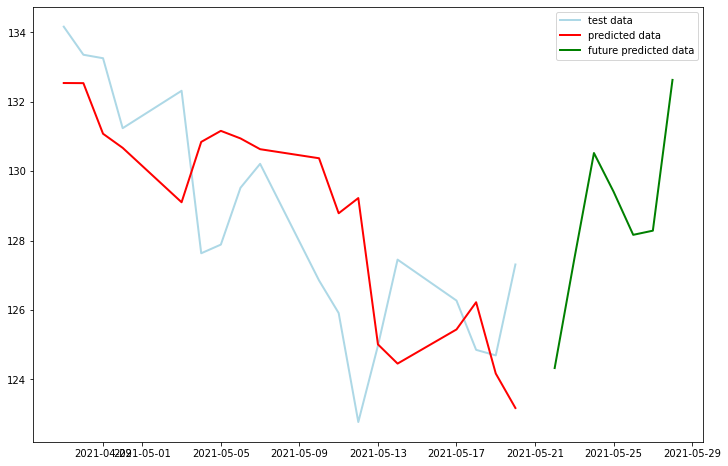

In [496]:
price_reg.evaluate_model_performance()